In [ ]:
!pip install wikipedia

In [ ]:
import pandas as pd
import wikipedia
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# NLTK downloads
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
wikipedia.set_lang("en")

articles = [
    'Data Science', 'Artificial intelligence', 'Machine learning',
    'European Central Bank', 'Bank', 'Financial technology',
    'International Monetary Fund', 'Basketball', 'Swimming', 'Tenis'
]

wiki_contents = []
titles = []

for article in articles:
    print("Loading:", article)
    try:
        page = wikipedia.page(article)
        wiki_contents.append(page.content)
        titles.append(article)
    except Exception as e:
        print("Error:", e)
        wiki_contents.append("")
        titles.append(article)


Loading: Data Science
Loading: Artificial intelligence
Loading: Machine learning
Error: Page id "machine ;earning" does not match any pages. Try another id!
Loading: European Central Bank
Loading: Bank
Loading: Financial technology
Loading: International Monetary Fund
Loading: Basketball
Loading: Swimming
Loading: Tenis


In [ ]:
for cluster_id in sorted(df["Cluster"].unique()):
    cluster_titles = df[df["Cluster"] == cluster_id]["Title"].tolist()
    print(f"\nCluster {cluster_id}:")
    for title in cluster_titles:
        print(f"  - {title}")


Cluster 0:
  - European Central Bank

Cluster 1:
  - Machine Learning
  - Tennis

Cluster 2:
  - Data Science

Cluster 3:
  - Swimming

Cluster 4:
  - Bank

Cluster 5:
  - Financial technology

Cluster 6:
  - Artificial intelligence

Cluster 7:
  - Basketball

Cluster 8:
  - International Monetary Fund


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    tokens = [t for t in tokens if len(t) > 2]
    return " ".join(tokens)

cleaned_contents = [clean_text(content) for content in wiki_contents]

df = pd.DataFrame({
    "Title": titles,
    "Raw_Content": wiki_contents,
    "Cleaned_Content": cleaned_contents
})

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
tfidf_matrix = tfidf.fit_transform(df["Cleaned_Content"])

In [ ]:
wcss = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(tfidf_matrix)
    wcss.append(km.inertia_)

# Auto-detect elbow using second derivative
delta = np.diff(wcss)
second_deriv = np.diff(delta)
elbow_k = np.argmax(second_deriv) + 2

print("Optimal k detected:", elbow_k)

Optimal k detected: 7


In [ ]:
kmeans_opt = KMeans(n_clusters=elbow_k, random_state=42)
df["Cluster"] = kmeans_opt.fit_predict(tfidf_matrix)

print("\nCluster assignments:")
print(df[["Title", "Cluster"]])


Cluster assignments:
                         Title  Cluster
0                 Data Science        2
1      Artificial intelligence        4
2             Machine learning        5
3        European Central Bank        0
4                         Bank        5
5         Financial technology        6
6  International Monetary Fund        0
7                   Basketball        1
8                     Swimming        3
9                        Tenis        1


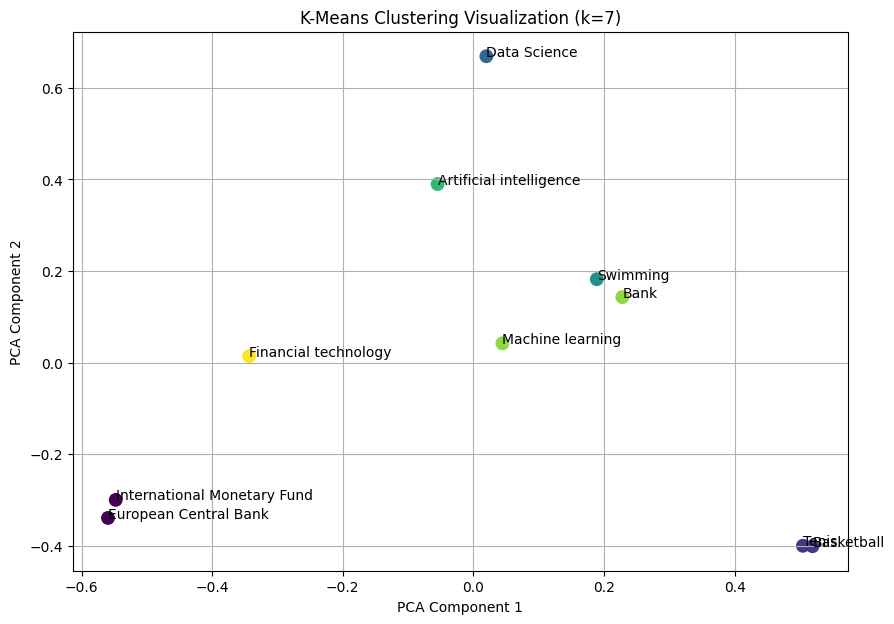

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10,7))
plt.scatter(coords[:,0], coords[:,1], c=df["Cluster"], s=80)

for i, title in enumerate(df["Title"]):
    plt.annotate(title, (coords[i,0], coords[i,1]))

plt.title(f"K-Means Clustering Visualization (k={elbow_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


Generating word clouds for each cluster...


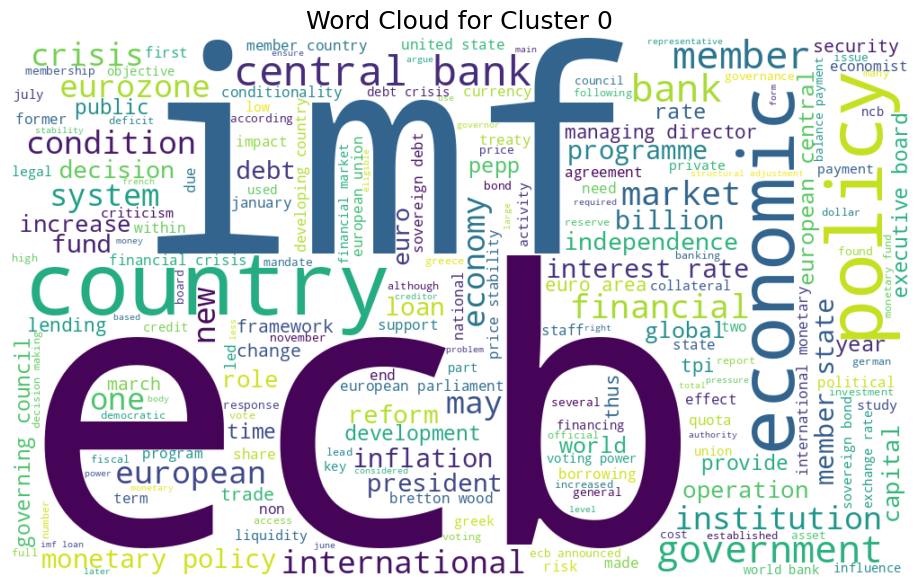

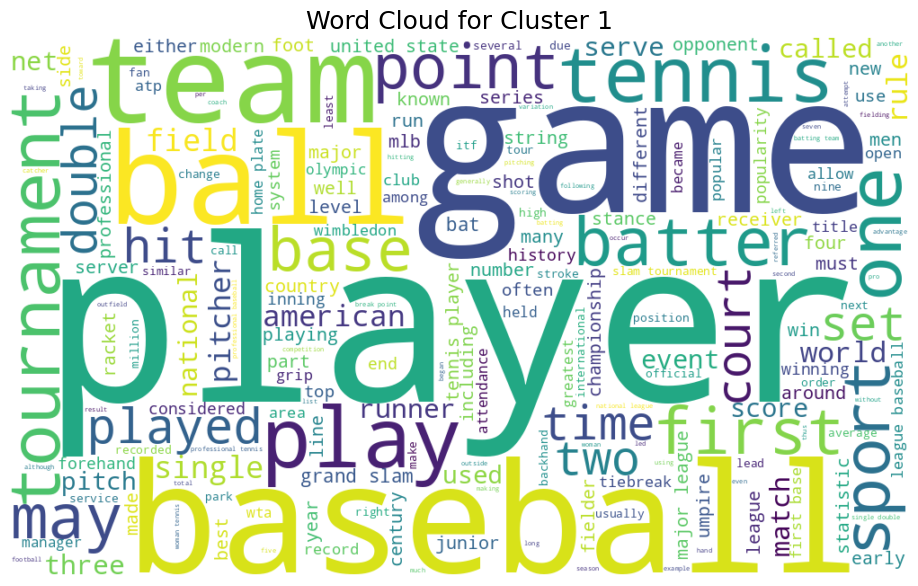

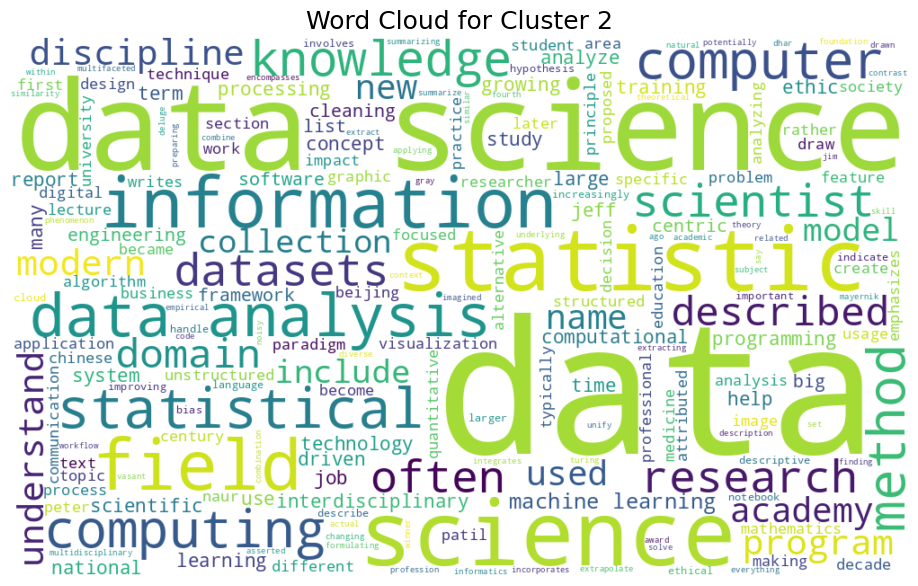

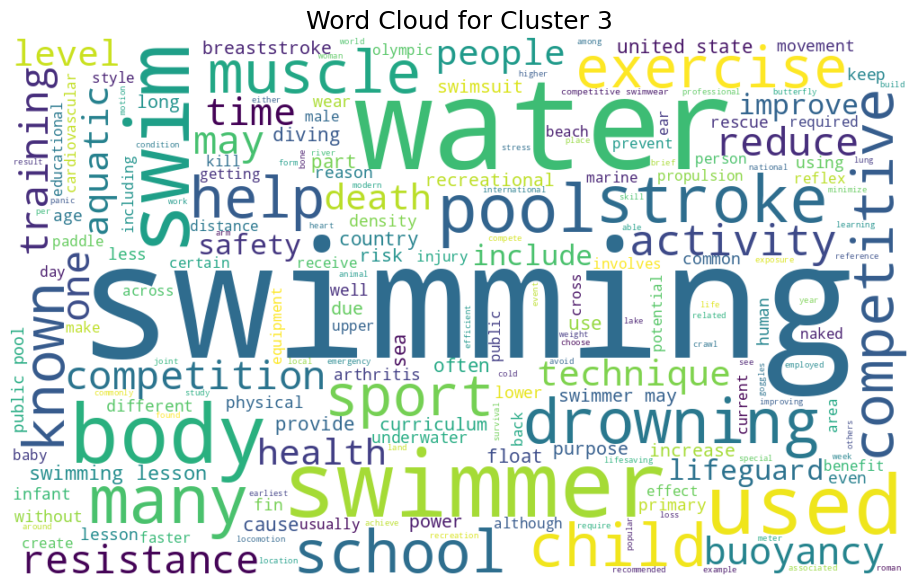

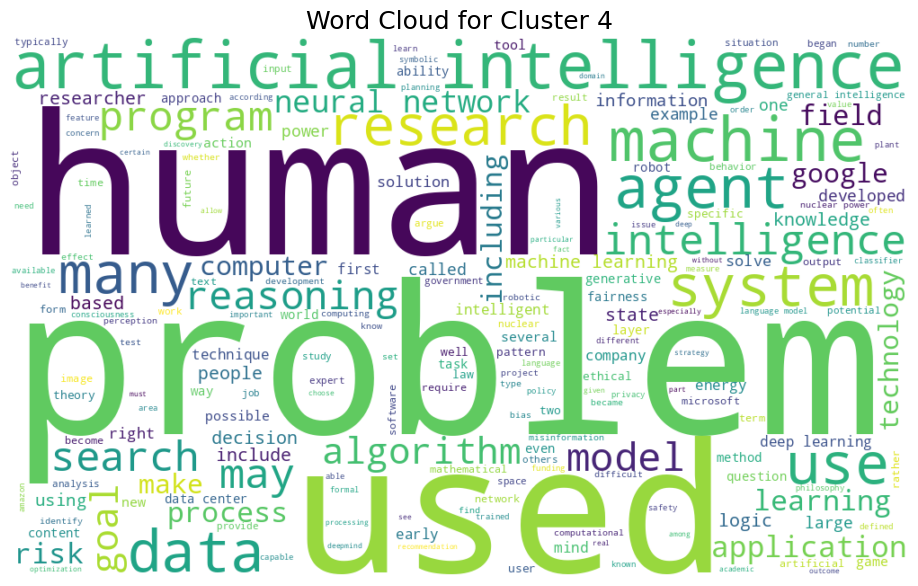

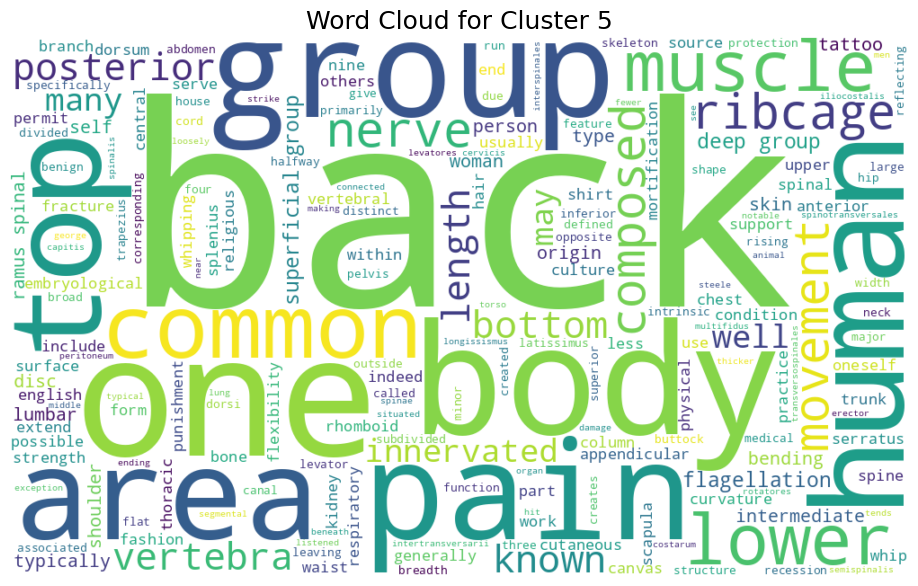

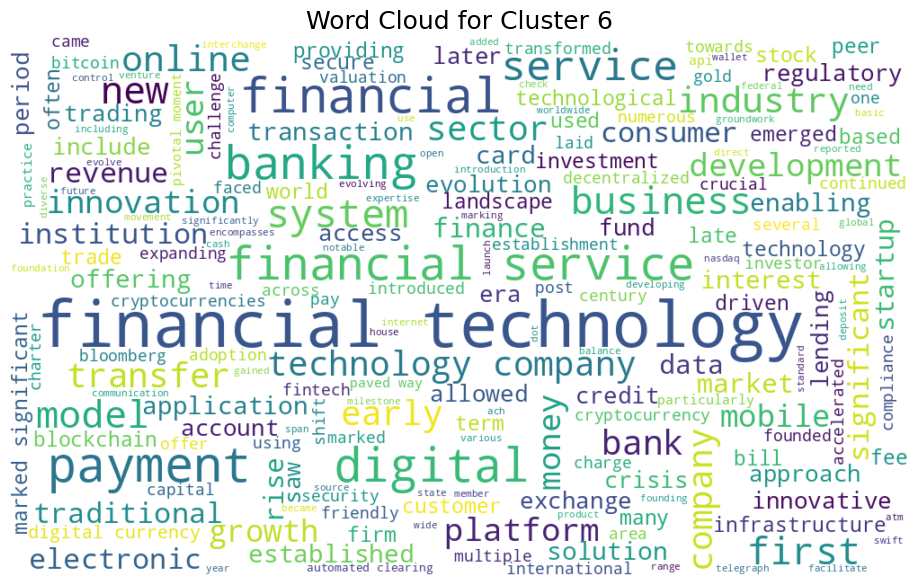

In [ ]:
print("\nGenerating word clouds for each cluster...")

for cluster_id in sorted(df["Cluster"].unique()):
    cluster_text = " ".join(df[df["Cluster"] == cluster_id]["Cleaned_Content"])

    if cluster_text.strip(): # Check if cluster_text is not empty or just whitespace
        wordcloud = WordCloud(
            width=1000,
            height=600,
            background_color='white',
            max_words=200
        ).generate(cluster_text)

        plt.figure(figsize=(12, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Word Cloud for Cluster {cluster_id}", fontsize=18)
        plt.show()
    else:
        print(f"Skipping word cloud for Cluster {cluster_id} as there is no content.")